In [1]:
import numpy as np
import scipy as p
import matplotlib.pyplot as plt
from scipy.odr import ODR, Model, RealData
from scipy import odr

In [4]:
def STLSQ(Theta: np.ndarray,dXdt: np.ndarray, lambd: float, n_iter: int = 10) -> np.ndarray:
                                                        
    # Initial ordinary least-squares fit
    Xi, *_ = np.linalg.lstsq(Theta, dXdt, rcond=None)

    for _ in range(n_iter):
        # Hard-threshold small coefficients
        smallinds = np.abs(Xi) < lambd
        Xi[smallinds] = 0.0

        # For each state variable, refit using the remaining “large” basis functions
        for ind in range(Xi.shape[1]):      # n = Xi.shape[1] (state dimension)
            biginds = ~smallinds[:, ind]    # True means this basis function is kept
            if not np.any(biginds):
                continue                    # Skip if the entire column was zeroed
            Xi[biginds, ind], *_ = np.linalg.lstsq(
                Theta[:, biginds],          # Reduced library matrix
                dXdt[:, ind],               # Target derivative for this state
                rcond=None
            )

    return Xi


True coefficients:      [ 3.  -2.   0.   0.5  0.   1. ]
Recovered coefficients: [ 3.01960013 -2.08989875 -0.20507489  0.84404811  0.25640407  0.70278417]
λ (threshold) chosen:   0.18456740206273323


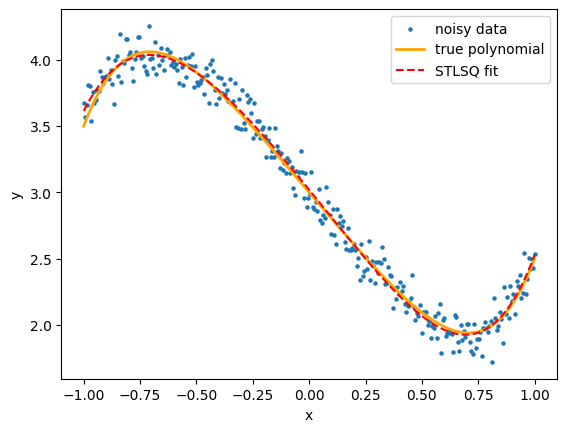

In [5]:
np.random.seed(0)

m = 300                                   # number of samples
x = np.linspace(-1, 1, m)
true_coeffs = np.array([3.0, -2.0, 0.0, 0.5, 0.0, 1])   # up to x^5
deg = len(true_coeffs) - 1
y_clean = sum(c * x**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)               # add y-noise only

# Build polynomial library Θ(x) = [1, x, x^2, …, x^deg]
Theta = np.vstack([x**k for k in range(deg + 1)]).T        # m × (deg+1)

# Choose λ slightly below the smallest non-zero coefficient
Xi_initial, *_ = np.linalg.lstsq(Theta, y_noisy[:, None], rcond=None)
nz = np.abs(Xi_initial)[np.abs(Xi_initial) > 1e-12]        # filter exact zeros
lambd = 0.9*nz.min()                                     # 90% of smallest non-zero

Xi_sparse = STLSQ(Theta, y_noisy[:, None], lambd=lambd, n_iter=10).ravel()    # flatten to 1-D

print("True coefficients:     ", true_coeffs)
print("Recovered coefficients:", Xi_sparse)
print("λ (threshold) chosen:  ", lambd)

y_fit = sum(Xi_sparse[k] * x**k for k in range(deg + 1))
plt.scatter(x, y_noisy, s=5, label='noisy data')
plt.plot(x, y_clean, color='orange', linewidth=2, label='true polynomial')
plt.plot(x, y_fit, '--', color='red', linewidth=1.5, label='STLSQ fit')
plt.legend(); plt.xlabel('x'); plt.ylabel('y'); plt.show()

True  coeffs: [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 2.98803894 -2.00904345  0.          0.52705949  0.03702859  0.98104567]
Chosen λ: 0.00650967523045817


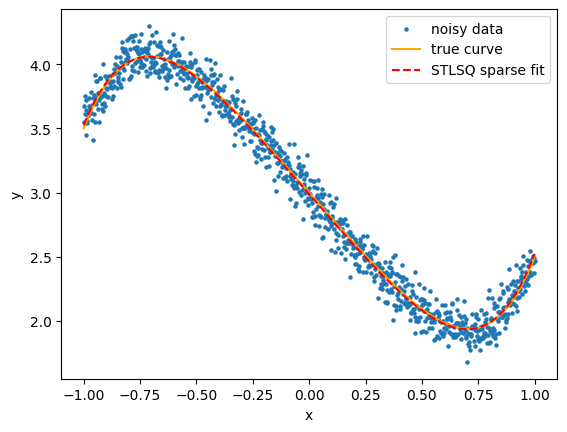

In [6]:
np.random.seed(0)
m = 1000
x = np.linspace(-1, 1, m)
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])   
deg = len(true_coeffs) - 1
y_clean = sum(c * x**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)

#  Construct and normalize the polynomial library
Theta = np.vstack([x**k for k in range(deg + 1)]).T
col_norms = np.linalg.norm(Theta, axis=0)
Theta_n = Theta                    # Normalize each column to unit norm
y = y_noisy[:, None]


# λ grid search with BIC
lambdas = np.logspace(-3, 0, 60)                # 0.001 → 1
best_bic, best_Xi, best_lam = np.inf, None, None
n = len(y_noisy)

for lam in lambdas:
    Xi_n = STLSQ(Theta_n, y, lam)               # Sparse regression on normalized library

    rss = np.sum((y_noisy - (Theta @ Xi_n).ravel())**2)
    k = np.count_nonzero(Xi_n)                    # # Number of non-zero coefficients
    bic = n * np.log(rss / n) + k * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi_n.ravel(), lam

#
print("True  coeffs:", true_coeffs)
print("Sparse coeffs:", best_Xi)
print("Chosen λ:", best_lam)

y_fit = sum(best_Xi[k] * x**k for k in range(deg + 1))
plt.scatter(x, y_noisy, s=5, label="noisy data")
plt.plot(x, y_clean, color = "orange", lw=1.5, label="true curve")
plt.plot(x, y_fit, "--", color = "red", lw=1.5, label="STLSQ sparse fit")
plt.legend(); plt.xlabel("x"); plt.ylabel("y"); plt.show()

In [25]:

def _odr_fit(A: np.ndarray, b: np.ndarray, beta0: np.ndarray | None = None) -> np.ndarray:
 
    # polynomial model
    def poly_model(beta, x):
        return np.dot(beta, x)

    model = odr.Model(poly_model)
    data  = odr.RealData(A.T, b, sx= 0.1, sy = 0.1)           

    if beta0 is None:                       # LSQ as the initial value
        beta0 = np.linalg.lstsq(A, b, rcond=None)[0]
    out = odr.ODR(data, model, beta0=beta0).run()
    return out.beta


def STLSQ_ODR(Theta: np.ndarray,
              dXdt: np.ndarray,
              lambd: float,
              n_iter: int = 10) -> np.ndarray:

    n_features, n_states = Theta.shape[1], dXdt.shape[1]
    Xi = np.zeros((n_features, n_states))

    # ODR fit
    for k in range(n_states):
        Xi[:, k] = _odr_fit(Theta, dXdt[:, k])

    # Iteration: thresholding + refitting
    for _ in range(n_iter):
        small = np.abs(Xi) < lambd
        Xi[small] = 0.0

        # Large coefficients retained by re-ODR fitting for each state
        for k in range(n_states):
            keep = ~small[:, k]
            if not np.any(keep):
                continue
            Xi[keep, k] = _odr_fit(Theta[:, keep], dXdt[:, k])

    return Xi

True  coeffs : [ 3.  -2.   0.   0.5  0.   1. ]
Sparse coeffs: [ 3.0458 -2.1742 -0.3082  1.5073  0.2517  0.    ]
Chosen λ     : 0.7912342618981326


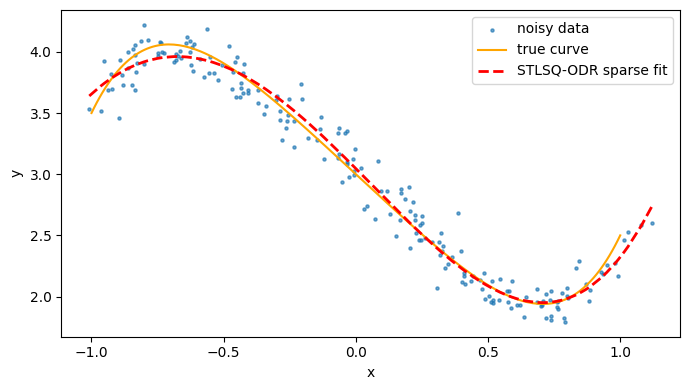

In [15]:
np.random.seed(0)
m = 200
x_true = np.linspace(-1, 1, m)

# Add noise to both x and y
x_noisy = x_true + 0.06 * np.random.randn(m)
true_coeffs = np.array([3, -2, 0, 0.5, 0, 1])
deg = len(true_coeffs) - 1
y_clean = sum(c * x_true**k for k, c in enumerate(true_coeffs))
y_noisy = y_clean + 0.1 * np.random.randn(m)

# Construct and normalize the polynomial library
Theta = np.vstack([x_noisy**k for k in range(deg + 1)]).T
col_norms = np.linalg.norm(Theta, axis=0)
Theta_n = Theta / col_norms                 # Normalize each column to unit norm
y = y_noisy[:, None]                        # Reshape to (m, 1)

# λ grid search + BIC
lambdas = np.logspace(-3, 0, 60)            # Range: 0.001 → 1
n = m
best_bic, best_Xi, best_lam = np.inf, None, None

for lam in lambdas:
    # Sparse regression (on normalized library)
    Xi_n = STLSQ_ODR(Theta_n, y, lam, n_iter=10)
    # Rescale coefficients back to original magnitude
    Xi = Xi_n / col_norms[:, None]

    # Residual sum of squares
    rss = np.sum((y_noisy - (Theta @ Xi).ravel())**2)
    k_nonzero = np.count_nonzero(Xi)
    bic = n * np.log(rss / n) + k_nonzero * np.log(n)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi.ravel(), lam


print("True  coeffs :", true_coeffs)
print("Sparse coeffs:", np.round(best_Xi, 4))
print("Chosen λ     :", best_lam)

y_fit = sum(best_Xi[k] * x_noisy**k for k in range(deg + 1))

plt.figure(figsize=(7, 4))
plt.scatter(x_noisy, y_noisy, s=5, alpha=0.65, label="noisy data")
plt.plot(x_true, y_clean, color="orange", lw=1.5, label="true curve")
plt.plot(np.sort(x_noisy), y_fit[np.argsort(x_noisy)],
         "--", color="red", lw=2, label="STLSQ-ODR sparse fit")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(); plt.tight_layout()
plt.show()


In [31]:
from scipy.integrate import odeint
from itertools import combinations_with_replacement

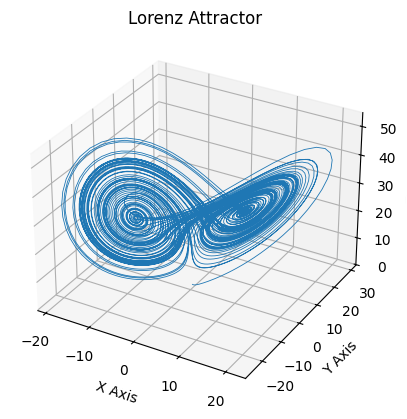

In [20]:
# initial code from wikipedia
def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.6)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [36]:
### Dataset

def lorenz63(state, t, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return (dxdt, dydt, dzdt)

# Integrate
sigma, rho, beta = 10.0, 28.0, 8 / 3
x0 = (-8, 8, 27)
dt = 0.01
t  = np.arange(0.0, 10 + dt, dt)
X_true = odeint(lorenz63, x0, t, args=(sigma, rho, beta)) # Trajectory


# add noise
noise_level = 0.01
rng = np.random.default_rng(0)
X_noisy = X_true + noise_level * rng.standard_normal(X_true.shape)

# Estimate using a second-order central difference
dXdt = np.gradient(X_noisy, dt, axis=0, edge_order=2)

In [37]:
def build_poly_library(X: np.ndarray, degree: int = 3, include_bias: bool = True):
    m, n = X.shape
    cols, names = [], []

    if include_bias:
        cols.append(np.ones(m))
        names.append('1')

    for d in range(1, degree + 1):
        for combo in combinations_with_replacement(range(n), d):
            col = np.prod(X[:, combo], axis=1)
            cols.append(col)
            names.append(''.join('xyz'[i] for i in combo))   
    return np.column_stack(cols), names

degree = 2
Theta, lib_names = build_poly_library(X_noisy, degree)

col_norms = np.linalg.norm(Theta, axis=0)

# # λ grid search + BIC
lambdas = np.logspace(-3, 0, 60) 
best_bic  = np.inf
best_Xi   = None
best_lam  = None
n_samples = len(t)

for lam in lambdas:
    Xi = STLSQ_ODR(Theta, dXdt, lam, n_iter=10)
    rss  = np.sum((dXdt - Theta @ Xi)**2)
    k    = np.count_nonzero(Xi)                   # the number of the none zero coefficient
    bic  = n_samples * np.log(rss / n_samples) + k * np.log(n_samples)

    if bic < best_bic:
        best_bic, best_Xi, best_lam = bic, Xi, lam

print(f"\n➜  Best λ = {best_lam:.3g}\n")
for state_name, coeffs in zip(["ẋ", "ẏ", "ż"], best_Xi.T):
    terms = [f"{c:+.3f}{n}" for c, n in zip(coeffs, lib_names) if abs(c) > 1e-3]
    print(f"{state_name} = {' '.join(terms)}")


# validate
def rhs_learned(state, t, Xi=best_Xi, deg=degree):
    """
    Generate a row of Θ(state), in the same order as build_poly_library and multiply with Xi to get (dx/dt, dy/dt, dz/dt)
    """
    x, y, z = state
    vars_ = [x, y, z]
    theta_row = [1.0]                # bias
    for d in range(1, deg + 1):
        for combo in combinations_with_replacement(range(3), d):
            prod = 1.0
            for idx in combo:
                prod *= vars_[idx]
            theta_row.append(prod)
    return (np.array(theta_row) @ Xi).tolist()

X_learned = odeint(rhs_learned, X_noisy[0], t)

# plot
fig = plt.figure(figsize=(12, 4))
for i, lbl in enumerate('xyz'):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.plot(t, X_true[:, i],  'k',  lw=1, label='true')
    ax.plot(t, X_learned[:, i], '--r', lw=1, label='learned')
    if i == 0:
        ax.legend()
    ax.set_xlabel('t'); ax.set_ylabel(lbl)
plt.tight_layout(); plt.show()

RuntimeError: could not generate output